# Trabalho ENGA75

### Autor: Allan Almeida

In [1]:
from ur5 import UR5, forward_kinematics
from math import pi
import numpy as np
import matplotlib.pyplot as plt
ur5 = UR5()
PI = pi

Inicializando a classe UR5...
Inicializando os nós e handles...
Pronto!


## Etapa A1

Implementar a Cinemática Direta e Inversa do Robô UR5. Validar a modelagem com o auxílio do
simulador para um conjunto de valores das variáveis das juntas (Cinemática Direta) e para um conjunto de
posições e orientações da garra (Cinemática Inversa)

#### Cinemática Direta

<img src="Cinemática Direta (DH).png" width="500">

In [ ]:
def validate_fk(ang):
    fk, _ = forward_kinematics(ang)    # Calcular cinemática direta a partir dos ângulos
    print('Cinemática Direta: ')
    print(fk)
    ur5.move_to_config(ang)     # Mover para a posição
    print('Ground Truth: ')
    gt = ur5.get_ground_truth()     # Obter Ground Truth
    print(gt)
    print('Erro: ', np.linalg.norm(fk-gt)/np.linalg.norm(gt)*100, '%')  # Calcular e printar erro

In [ ]:
validate_fk([.5*PI, .05*PI, .45*PI, 0, -.5*PI, .5*PI])

In [ ]:
validate_fk([-.5*PI, -.05*PI, -.45*PI, 0, .5*PI, .5*PI])

In [ ]:
validate_fk([PI/2, 0, 0, 0, 0, 0])

In [ ]:
validate_fk([.1*PI, .18*PI, .57*PI, 0.25*PI, 0.2, PI/2])

In [ ]:
validate_fk([-.3*PI, -.04*PI, -.8*PI, -0.17*PI, -0.5, PI/2])

In [ ]:
validate_fk([0.2, .04*PI, .8*PI, 0.17*PI, 0.3, PI/2])

#### Cinemática Inversa

<img src="gripper.jpg" width="700">

In [2]:
ur5.move_to_pose([-0.1, -.55, .4], [PI, 0, PI/2], wrist='up')

Iterações totais:  127
Erro pose final:  1.1815998466586801 %


In [4]:
ur5.move_to_pose([-0.1, -.55, .4], [0, 0, -PI/2], wrist='down')

Iterações totais:  189
Erro pose final:  1.218541846417765 %


In [3]:
ur5.move_to_pose([-0.1, -.55, .4], [PI/2, 0, -PI/2], wrist='down')

Iterações totais:  249
Erro pose final:  1.2974669871618116 %


In [ ]:
ur5.move_to_pose([-0.1, -.45, .4], [PI/2, 0, -PI/2], wrist='down')

In [2]:
ur5.move_to_pose([-0.1, -.45, .25], [PI/2, 0, -PI/2], wrist='down')

Iterações totais:  193
Erro pose final:  1.3008660097231264 %


## Etapa A2

Implementar um sistema de planejamento de trajetórias no espaço de juntas com uma das abordagens
abaixo:

1. Trajetórias polinomiais cúbicas ou de quinto grau;
2. Linear Segments with Parabolic Blends (LSPB);
3. Minimum Time Trajectories

<b>Polinômio de Quinto Grau</b>

$q(t) = a_0+a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5$

$\dot{q}(t) = a_1 + 2 a_2 t + 3 a_3 t^2 + 4 a_4 t^3 + 5 a_5 t^4$

$\ddot{q}(t) = 2 a_2 + 6 a_3 t + 12 a_4 t^2 + 20 a_5 t^3$

$\begin{bmatrix}
1 & t_0 & t_0^2 & t_0^3 & t_0^4 & t_0^5\\
0 & 1 & 2t_0 & 3t_0^2 & 4t_0^3 & 5t_0^4\\
0 & 0 & 2 & 6t_0 & 12t_0^2 & 20t_0^3\\
1 & t_f & t_f^2 & t_f^3 & t_f^4 & t_f^5\\
0 & 1 & 2t_f & 3t_f^2 & 4t_f^3 & 5t_f^4\\
0 & 0 & 2 & 6t_f & 12t_f^2 & 20t_f^3\\
\end{bmatrix} \cdot \begin{bmatrix}
a_0\\
a_1\\
a_2\\
a_3\\
a_4\\
a_5\\
\end{bmatrix} = \begin{bmatrix}
q_0\\
\dot{q}_0\\
\ddot{q}_0\\
q_f\\
\dot{q}_f\\
\ddot{q}_f\\
\end{bmatrix}$


$A\cdot X = B$

In [3]:
t, max_err, mean_err, graphs, _ = ur5.move_to_config([.5*PI, .05*PI, .45*PI, 0, .5*PI, .3*PI], graph=True)

Iterações totais:  306


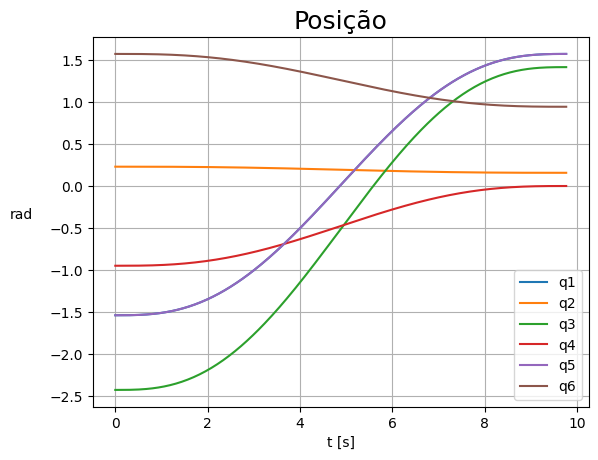

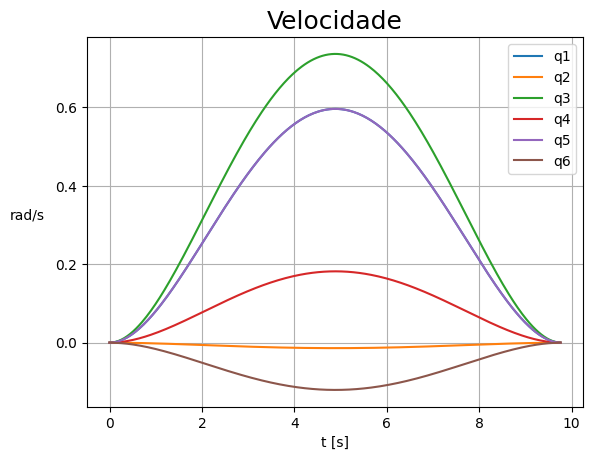

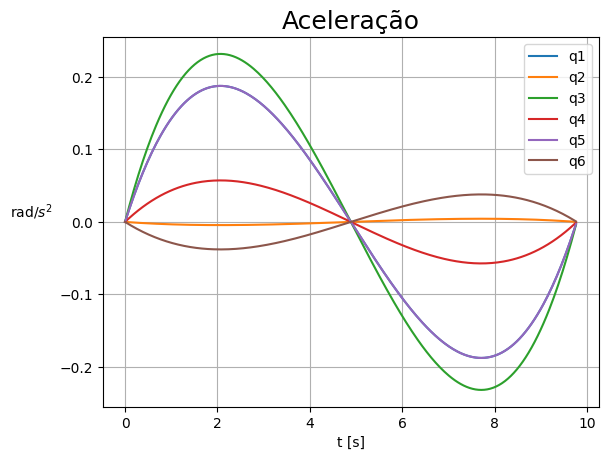

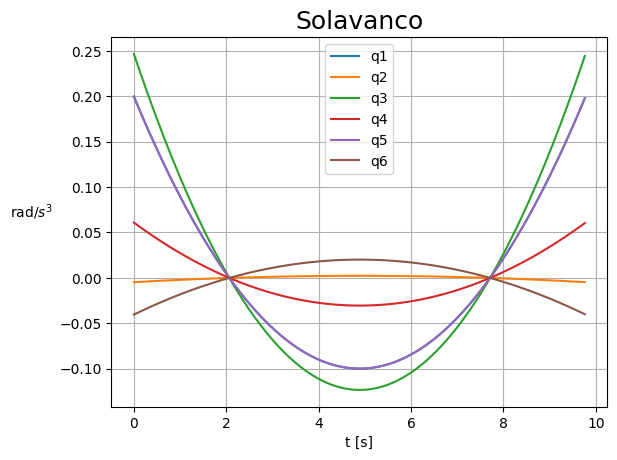

In [4]:
titles = ['Posição', 'Velocidade', 'Aceleração', 'Solavanco']
axes = ['rad', 'rad/s', 'rad/$s^2$', 'rad/$s^3$']

for i in range(4):
    for j in range(6):
        plt.plot(graphs[4][j], graphs[i][j])
    plt.legend(['q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    plt.grid()
    plt.title(titles[i], fontsize=18)
    plt.ylabel(axes[i], rotation=0, labelpad=20)
    plt.xlabel('t [s]')
    plt.show()

## Jacobiano

In [6]:
_, _, _, _, _ = ur5.move_to_config([0, 0, 0, 0, 0, 0])

Iterações totais:  126


In [7]:
_, _, _, graphs, jacob = ur5.move_to_config([0, -PI/2, 0, 0, 0, 0], graph=True, jacob=True, duration=None)

Iterações totais:  125


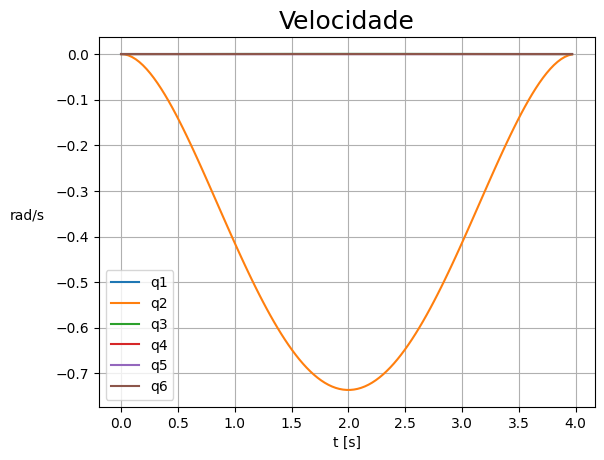

In [8]:
for j in range(6):
    plt.plot(graphs[4][j], graphs[1][j])
plt.legend(['q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
plt.grid()
plt.title('Velocidade', fontsize=18)
plt.ylabel('rad/s', rotation=0, labelpad=20)
plt.xlabel('t [s]')
plt.show()

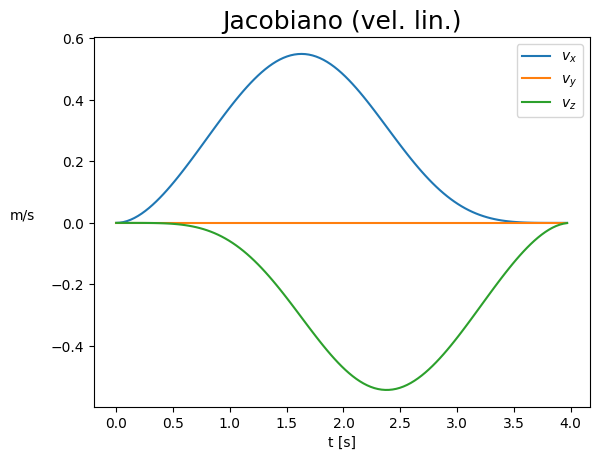

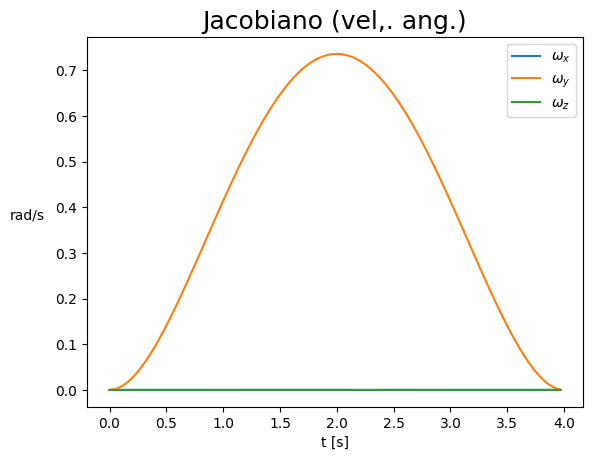

In [9]:
for j in range(3):
    plt.plot(graphs[4][j], [i[j] for i in jacob])
plt.title('Jacobiano (vel. lin.)', fontsize=18)
plt.legend(['$v_x$', '$v_y$', '$v_z$'])
plt.xlabel('t [s]')
plt.ylabel('m/s', rotation=0, labelpad=20)
plt.show()

for j in range(3, 6):
    plt.plot(graphs[4][j], [i[j] for i in jacob])
plt.title('Jacobiano (vel,. ang.)', fontsize=18)
plt.legend(['$\omega_x$', '$\omega_y$', '$\omega_z$'])
plt.xlabel('t [s]')
plt.ylabel('rad/s', rotation=0, labelpad=20)
plt.show()

In [ ]:
ur5.actuate_gripper(close=0)

In [ ]:
ur5.move_to_config([0, 0, 0, 0, 0, 0])

In [ ]:
ur5.move_to_config([.5*pi, .05*pi, .45*pi, 0, -.5*pi, .5*pi])

In [ ]:
ur5.move_to_config([.4*pi, .18*pi, .57*pi, 0.25*pi, 0.8, PI/2])

In [ ]:
# bottle = supervisor.getFromDef('bottle')

In [ ]:
# bottle.getField('translation').setSFVec3f([-1.467559345817077, 1.7836801495521285e-06, 0.9004484925267724])

In [ ]:
# bottle.getField('translation').getSFVec3f()